In [1]:
''' RNN Bidireccional en Keras '''
__author_ = '@Tssp'
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats.stats import pearsonr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.dates as mdates
from utils.NNutils import *
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['axes.labelsize']=16
plt.rcParams['axes.titlesize']=16

In [2]:
# Radon
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
newValuesReal = np.loadtxt('../../mdnRnA_validation.txt', delimiter=',')
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
dates[-1]

Timestamp('2019-07-21 00:00:00', freq='W-SUN')

In [5]:
len(newValuesReal) + len(mdnRnA)

325

In [209]:
# Weather
NVR = pd.read_csv('../Data/Daily/NVR/NVR_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
NVR['fecha'] = pd.to_datetime(NVR['fecha'])
NVR.describe()

,tmed,velmedia,presmed
count,316.000000,316.000000,316.000000
mean,13.614248,3.577390,965.829927
std,6.472158,1.177355,5.245625
min,1.271429,0.528571,947.739409
25%,7.857143,2.782143,963.025000
50%,13.657143,3.542857,965.839286
75%,18.934184,4.378571,968.598214
max,26.957143,6.585714,980.928571


In [210]:
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'T': NVR['tmed'].values})
DF.head()

,T,dates,mdnRnA
0,21.800000,2013-07-07,90.0
1,25.271429,2013-07-14,79.0
2,24.614286,2013-07-21,99.0
3,25.842857,2013-07-28,117.0
4,25.314286,2013-08-04,99.0


In [211]:
def scaler(DF, field):
    scaled = MinMaxScaler().fit(DF[[field[0], field[1]]].values).transform(DF[[field[0], field[1]]].values)
    output = pd.DataFrame(scaled, columns=['T', 'mdnRnA'])
    output['dates'] = DF['dates']
    return output, scaler
DF_scaled, scaled = scaler(DF, ['T', 'mdnRnA'])
DF_scaled.head()

,T,mdnRnA,dates
0,0.799221,0.573333,2013-07-07
1,0.934372,0.426667,2013-07-14
2,0.908788,0.693333,2013-07-21
3,0.956618,0.933333,2013-07-28
4,0.936040,0.693333,2013-08-04


In [212]:
sample_size = 52
# dataframe (empty) creation
pdata = pd.DataFrame()
pdatamdnRnA = pd.DataFrame()
names=list()
#print('pdata_raw 0',pdata_raw)
print('pdata 0',pdata)

pdata 0 Empty DataFrame
Columns: []
Index: []


In [213]:
nlags= len(newValuesReal)-1
for i in range(nlags, -1, -1):
    # Add the new lagged column at the end of the dataframe. In inverse order.
    pdata = pd.concat([pdata, DF_scaled[['T', 'mdnRnA']].shift(i).reset_index(drop=True)], axis=1)
    pdatamdnRnA = pd.concat([pdatamdnRnA, DF['mdnRnA'].shift(i).reset_index(drop=True)], axis=1)
    names += str(i) # store this index for naming the columns of dataframe

In [214]:
pdatamdnRnA.head(7)

,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,79.0
2,NaN,NaN,NaN,NaN,NaN,NaN,90.0,79.0,99.0
3,NaN,NaN,NaN,NaN,NaN,90.0,79.0,99.0,117.0
4,NaN,NaN,NaN,NaN,90.0,79.0,99.0,117.0,99.0
5,NaN,NaN,NaN,90.0,79.0,99.0,117.0,99.0,99.0
6,NaN,NaN,90.0,79.0,99.0,117.0,99.0,99.0,86.0


In [215]:
pdatalags = np.asarray(pdata[nlags:])
pdatamdnRnAlags = np.asarray(pdatamdnRnA[nlags:])
pdatalags.shape

(308, 18)

In [216]:
X = np.array([pdatalags[start:start+sample_size] for start in range(0, pdatalags.shape[0]-sample_size)])
Y = pdatamdnRnAlags[sample_size:]
Y.shape

(256, 9)

In [217]:
test_size = int(0.3*len(mdnRnA))
X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]
print("X_train.shape = ", X_train.shape, "\nY_train.shape = ", Y_train.shape)

X_train.shape =  (162, 52, 18) 
Y_train.shape =  (162, 9)


In [218]:
def NN_v2(neurons, nep, X_train, Y_train, X_test, Y_test, sample_size, v=0, btch_size=10, save=False):
    model = Sequential()
    model.add(Conv1D(filters=int(neurons[0]), kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv1D(filters=int(neurons[1]), kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(int(neurons[0]/2), activation='relu'))
    model.add(Dense(int(neurons[1]/2), activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='linear'))
    model.compile(loss="mae", optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, Y_train, epochs=nep, batch_size=btch_size, verbose=v, validation_data=(X_test, Y_test))
    pred = model.predict(X_test)
    acc_train = np.average(history.history["acc"])
    acc_test = np.average(history.history["val_acc"])
    if save:
        save_NN(model)
    return history, pred, acc_train, acc_test, model

In [219]:
neuron = [256, 128]
history, pred, acc_train, acc_test, model = NN_v2(neuron, 90, X_train, Y_train, X_test, Y_test, sample_size)

In [220]:
predmaxs, predmins, predavgs = extract_maxs_mins_avgs(pred)

ECM: 60.3722
EAM: 5.9982
6.367832325874491


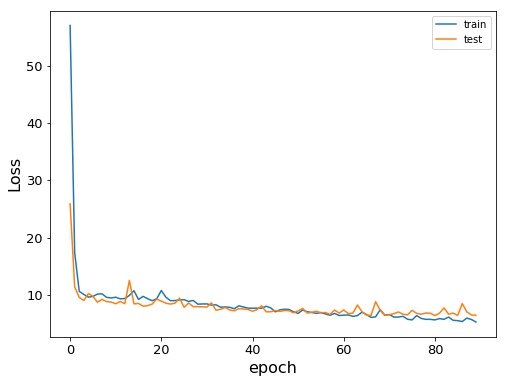

In [221]:
Y_test_error = DF[DF['dates'] > '2017-08-06']['mdnRnA']
testScoreECM = mean_squared_error(Y_test_error, predavgs)
print('ECM: %.4f' % (testScoreECM))
testScoreEAM = mean_absolute_error(Y_test_error, predavgs)
print('EAM: %.4f' % (testScoreEAM))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
print(np.min(history.history['val_loss']))

In [222]:
startday = pd.datetime(2013, 7, 1)
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D') - 7*pd.Timedelta(8, unit='D')
startdayahead = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA), unit='D')

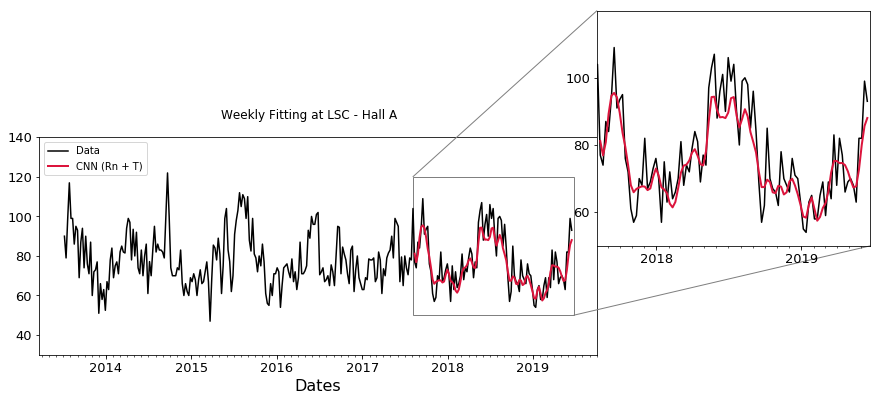

In [223]:
plot_forecast(mdnRnA, startday, predavgs, startdaypred)

In [224]:
# Pronostico:
Xval = np.atleast_3d(np.array([pdatalags[-sample_size:]]))
predval = model.predict(Xval)[0,:]

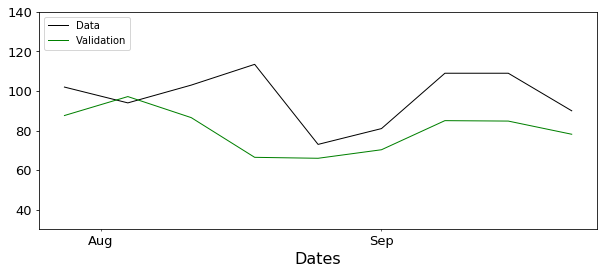

In [225]:
plot_validation(newValuesReal, predval, startdayahead)

In [226]:
# np.savetxt('CNN_Loss_RnT_PMP_{}_{}_v2.txt'.format(neuron[0], neuron[1]), (history.history['loss'], history.history['val_loss']), delimiter=',')
# np.savetxt('CNN_RnT_PMP_{}_{}_v2.txt'.format(neuron[0], neuron[1]), (predmins, predmaxs, predavgs), delimiter=',', fmt='%s')

In [227]:
dist = DF[DF['dates'] > '2017-08-06']['mdnRnA'] - predavgs

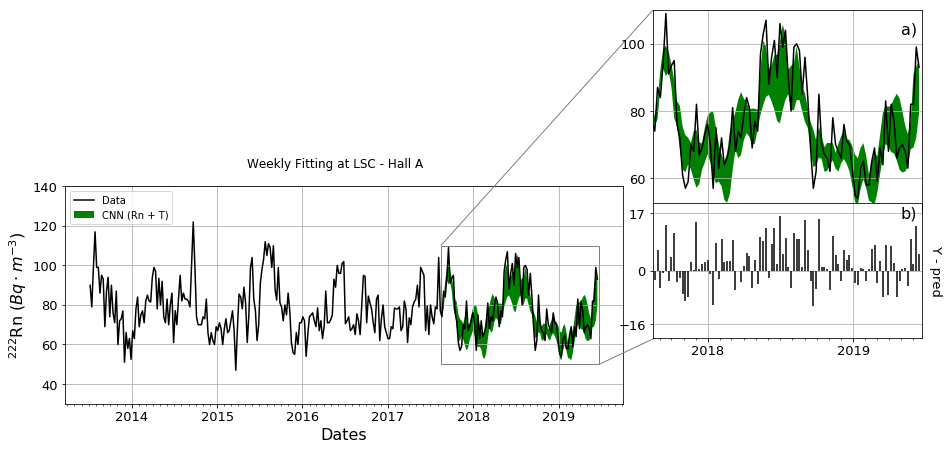

In [228]:
plot_fill_errors(mdnRnA, predmins, predmaxs, predavgs, dist, startday, startdaypred)

In [229]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 50, 256)           14080     
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 48, 128)           98432     
_________________________________________________________________
flatten_23 (Flatten)         (None, 6144)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 6144)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               786560    
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_68 (Dense)             (None, 9)                 585       
Total para

# Only $^{222}Rn$

In [230]:
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
newValuesReal = np.loadtxt('../../mdnRnA_validation.txt', delimiter=',')
nlags= len(newValuesReal)-1
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
# Weather
NVR = pd.read_csv('../Data/Daily/NVR/NVR_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
NVR['fecha'] = pd.to_datetime(NVR['fecha'])
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'tmed': NVR['tmed'].values})
def scaler(DF, field):
    scaled = MinMaxScaler().fit(DF[[field[0], field[1]]].values).transform(DF[[field[0], field[1]]].values)
    output = pd.DataFrame(scaled, columns=['tmed', 'mdnRnA'])
    output['dates'] = DF['dates']
    return output, scaler
DF_scaled, scaled = scaler(DF, ['tmed', 'mdnRnA'])
sample_size = 52
# dataframe (empty) creation
pdata = pd.DataFrame()
pdatamdnRnA = pd.DataFrame()
names=list()
nlags= len(newValuesReal)-1
for i in range(nlags, -1, -1):
    # Add the new lagged column at the end of the dataframe. In inverse order.
    pdata = pd.concat([pdata, DF_scaled[['tmed', 'mdnRnA']].shift(i).reset_index(drop=True)], axis=1)
    pdatamdnRnA = pd.concat([pdatamdnRnA, DF['mdnRnA'].shift(i).reset_index(drop=True)], axis=1)
    names += str(i) # store this index for naming the columns of dataframe
pdatalags = np.asarray(pdata[nlags:])
pdatamdnRnAlags = np.asarray(pdatamdnRnA[nlags:])   
X = np.atleast_3d(np.array([pdatamdnRnAlags[start:start + sample_size]
    for start in range(0, pdatamdnRnAlags.shape[0]-sample_size)]))
Y = pdatamdnRnAlags[sample_size:]
test_size = int(0.3*len(mdnRnA))
X_train,X_test = X[:-test_size], X[-test_size:]
Y_train,Y_test = Y[:-test_size], Y[-test_size:]

In [246]:
neuron = [128, 64]
history, pred, acc_train, acc_test, model = NN_v2(neuron, 80, X_train, Y_train, X_test, Y_test, sample_size)
predmaxs, predmins, predavgs = extract_maxs_mins_avgs(pred)

ECM: 85.5464
EAM: 7.4292
5.27444570115272


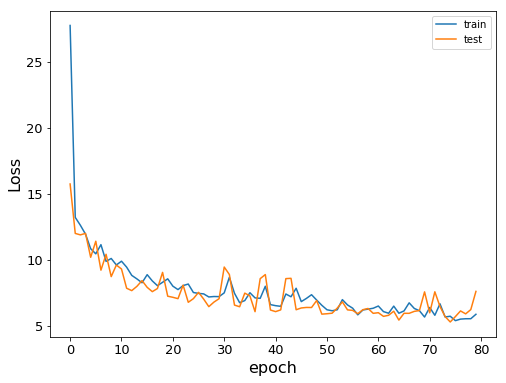

In [247]:
Y_test_error = DF[DF['dates'] > '2017-08-06']['mdnRnA']
testScoreECM = mean_squared_error(Y_test_error, predavgs)
print('ECM: %.4f' % (testScoreECM))
testScoreEAM = mean_absolute_error(Y_test_error, predavgs)
print('EAM: %.4f' % (testScoreEAM))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
print(np.min(history.history['val_loss']))

In [248]:
# Pronostico:
Xval = np.atleast_3d(np.array([pdatamdnRnAlags[-sample_size:]]))
predval = model.predict(Xval)[0,:]

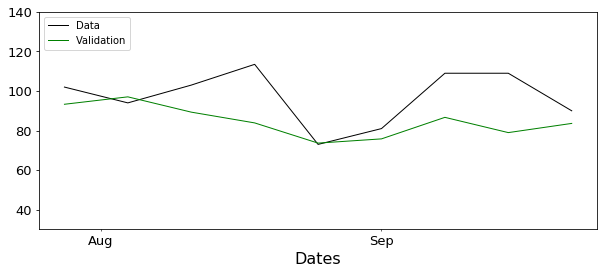

In [249]:
plot_validation(newValuesReal, predval, startdayahead)

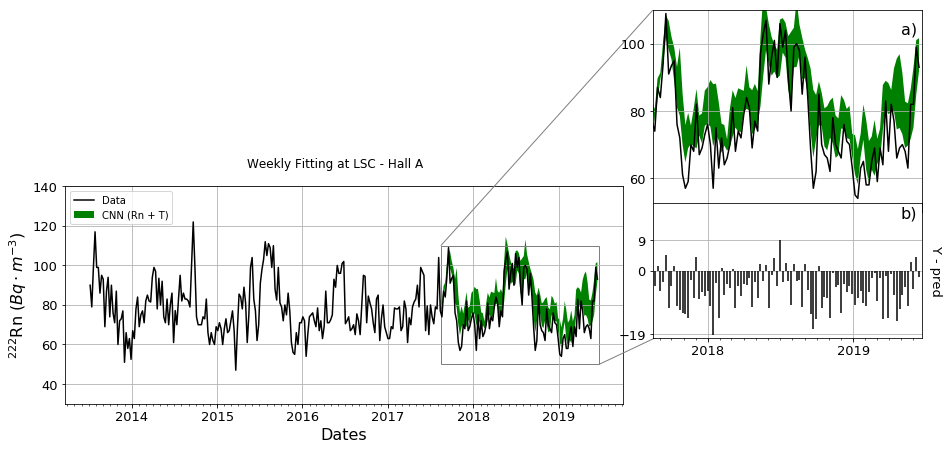

In [250]:
dist = DF[DF['dates'] > '2017-08-06']['mdnRnA'] - predavgs
plot_fill_errors(mdnRnA, predmins, predmaxs, predavgs, dist, startday, startdaypred)